In [21]:
from pyspark.sql.functions import mean, udf, col, round
from pyspark.sql.types import DoubleType
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
%matplotlib inline

## import csv files into spark dataframes
Note: both files contain records from all 5 boroughs

In [8]:
df17v11 = spark.read.csv('data/pluto_17v11.csv', header=True)
df18v1 = spark.read.csv('data/pluto_18v1.csv', header=True)

In [9]:
double_columns = ['bldgarea', 'facilfar',
                  'residfar', 'commfar', 'numbldgs', 'numfloors', 'bldgdepth', 
                  'bldgfront', 'lotdepth', 'lotfront', 
                  'exempttot', 'exemptland', 'builtfar']
for A in double_columns: 
    df17v11 = df17v11.withColumn(A, round(col(A).cast(DoubleType()), 2))
    df18v1 = df18v1.withColumn(A, round(col(A).cast(DoubleType()), 2))

## Change column names and joining dataframes
* since we are doing column comparison, we need to the column names of one df to avoid confusion
* in this case, we add "_1"_ to the name, e.g. "BBL" ==> "BBL_1"
* here we are doing an inner join because we only care about the BBL's that apeared in both dataframes

In [10]:
df17v11 = df17v11.select([col(A).alias(A+'_1') for A in df17v11.schema.names])

In [11]:
df18v1_names = df18v1.schema.names
df17v11_names = df17v11.schema.names
colnames = zip(df18v1_names, df17v11_names)

In [12]:
df = df18v1.join(df17v11, df18v1['BBL'] == df17v11['BBL_1'])

## Create UDF (user defined function) for column comparison
* by doing ```@udf``` decorator, we are basically telling spark to optimize this function for column wise paralellized operations (it's a black box to me) 

In [13]:
@udf
def compare(col1,col2):
    if col1!=col2:
        return 1
    else:
        return 0

## Generate results
1. generate the mismatch dummy column 
2. get rid of the original valued columns
3. calculate the mean (in this case represents the percentage of mismatches) and produce output

In [14]:
spark.sql('set spark.sql.caseSensitive=true')
for A,B in colnames:
    df = df.withColumn(A+'%', compare(col(A),col(B)))\
               .drop(A,B)
results = df.select(*[mean(col(A)).alias(A) for A in df.schema.names])

## Convert spark dataframe to pandas dataframe 
so we can easily export as a csv or conduct further analysis/visualizations

In [15]:
start_time = time.time()
results_df = results.toPandas()
elapsed_time = time.time() - start_time

In [16]:
results_df

,Borough%,Block%,Lot%,CD%,CT2010%,CB2010%,SchoolDist%,Council%,ZipCode%,FireComp%,...,ZMCode%,Sanborn%,TaxMap%,EDesigNum%,APPBBL%,APPDate%,PLUTOMapID%,FIRM07_FLAG%,PFIRM15_FLAG%,Version%
0,0.0,0.0,0.0,0.000002,0.003492,0.001272,0.087959,0.000537,0.000772,0.000529,...,0.000297,0.003862,0.001294,0.001034,0.00219,0.07836,0.001308,0.0,0.0,1.0


In [17]:
elapsed_time

114.09073686599731

In [18]:
results_df.iloc[0,:].sort_values(ascending=False)[0:30]

Version%          1.000000
LandUse%          0.952882
AssessTot%        0.893309
Tract2010%        0.888493
AssessLand%       0.875210
SanitDistrict%    0.562231
exempttot%        0.493090
exemptland%       0.460640
SchoolDist%       0.087959
OwnerName%        0.082888
APPDate%          0.078360
BsmtCode%         0.070894
BldgClass%        0.010595
bldgarea%         0.010127
builtfar%         0.010024
ResArea%          0.008689
ProxCode%         0.007521
UnitsTotal%       0.007302
numbldgs%         0.006054
bldgdepth%        0.005492
UnitsRes%         0.005407
numfloors%        0.005126
ComArea%          0.004686
bldgfront%        0.004370
Address%          0.004218
AreaSource%       0.004211
HistDist%         0.003875
Sanborn%          0.003862
YearAlter1%       0.003733
CT2010%           0.003492
Name: 0, dtype: float64

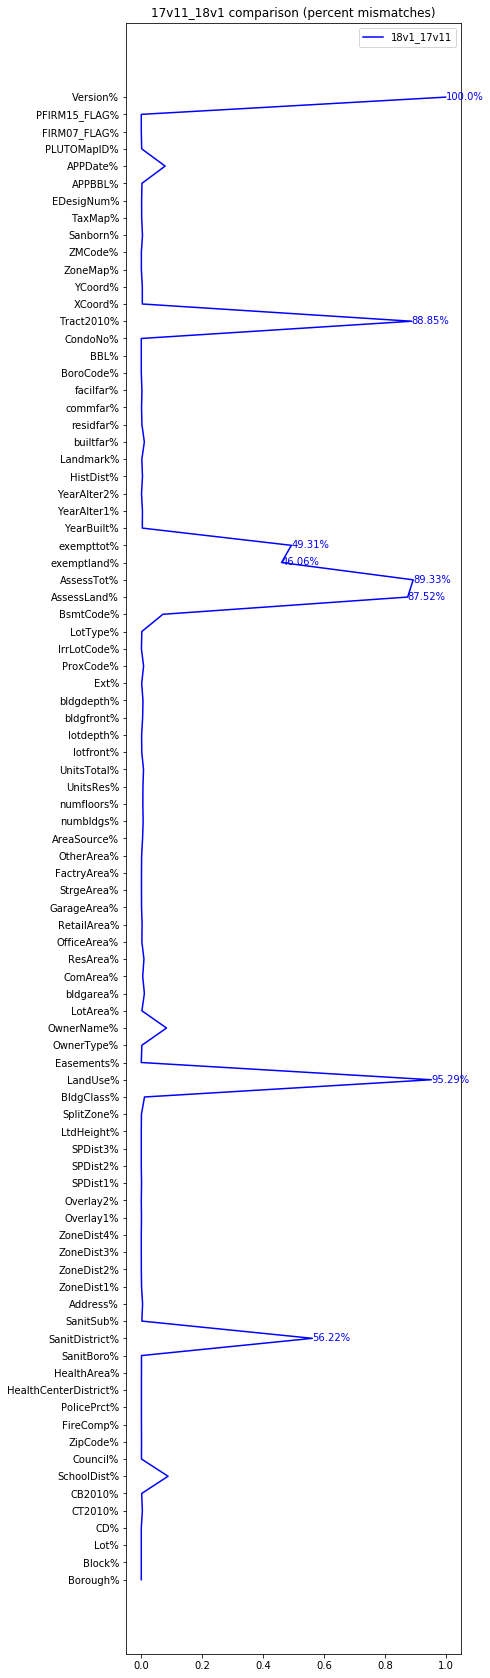

In [30]:
plt.figure(figsize=(6, 30))
plt.plot(results_df.iloc[0, :], range(87), label = '18v1_17v11', color = 'blue')
label = list(results_df.iloc[0, :])

for i in range(len(label)):
    if label[i] >= 0.1:
        plt.text(x = label[i] , y = i-0.15, s = '{}%'.format(np.round(label[i]*100, 2)), size = 10, color = 'blue')
    else: 
        pass

plt.yticks(range(87), results_df.columns, rotation='horizontal')
plt.title('17v11_18v1 comparison (percent mismatches)')
plt.legend()
plt.savefig('17v11_18v1_comparison.png', bbox_inches='tight')
plt.show()

In [25]:
results_df.to_csv('results_17v11_18v1.csv', index = False)